In [ ]:
# Create model_specialization.py
%%writefile model_specialization.py

import os
import json
import torch
import re
from transformers import RobertaTokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset
from typing import List, Dict, Any
from tqdm import tqdm

def determine_complexity(code: str) -> str:
    """Determine code complexity based on various factors"""
    # Simple heuristics for complexity
    code_length = len(code.split())

    # Count advanced TypeScript features
    generics_count = len(re.findall(r'<[^>]+>', code))
    union_types_count = len(re.findall(r'[^|]\|[^|]', code))
    interface_count = len(re.findall(r'interface\s+', code))

    # Calculate complexity score
    complexity_score = code_length + (generics_count * 5) + (union_types_count * 3) + (interface_count * 4)

    if complexity_score < 50:
        return "simple"
    elif complexity_score < 150:
        return "medium"
    else:
        return "complex"

def train_specialized_model(
    base_model_path: str,
    train_data_path: str,
    target_complexity: str,
    output_dir: str,
    epochs: int = 5,
    batch_size: int = 4,
    learning_rate: float = 3e-5
):
    """Train a specialized model for a specific complexity level"""
    # Load data
    with open(train_data_path, 'r') as f:
        all_data = json.load(f)

    # Filter by complexity
    filtered_data = []
    for example in tqdm(all_data, desc=f"Filtering {target_complexity} examples"):
        complexity = determine_complexity(example['input'])
        if complexity == target_complexity:
            filtered_data.append(example)

    print(f"Found {len(filtered_data)} examples of {target_complexity} complexity")

    if len(filtered_data) < 50:
        print(f"Not enough examples for {target_complexity} complexity. Aborting.")
        return None

    # Create directory
    os.makedirs(output_dir, exist_ok=True)

    # Initialize tokenizer and model
    tokenizer = RobertaTokenizer.from_pretrained(base_model_path)
    model = T5ForConditionalGeneration.from_pretrained(base_model_path)

    # Enable gradient checkpointing for memory efficiency
    model.gradient_checkpointing_enable()

    # Create training dataset
    def tokenize_function(examples):
        # Format inputs
        inputs = [f"Generate documentation for TypeScript code: {item['input']}" for item in examples]
        outputs = [item['output'] for item in examples]

        # Tokenize inputs
        model_inputs = tokenizer(
            inputs,
            max_length=512,
            padding="max_length",
            truncation=True
        )

        # Tokenize outputs
        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                outputs,
                max_length=256,
                padding="max_length",
                truncation=True
            )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    # Process training data in batches for efficiency
    tokenized_train_dict = {
        'input_ids': [],
        'attention_mask': [],
        'labels': []
    }

    # Process in batches to maintain efficiency
    batch_size_processing = 50
    for i in range(0, len(filtered_data), batch_size_processing):
        batch_end = min(i + batch_size_processing, len(filtered_data))
        batch = filtered_data[i:batch_end]
        tokenized_batch = tokenize_function(batch)

        # Add to dictionary
        for key in tokenized_train_dict:
            tokenized_train_dict[key].extend(tokenized_batch[key])

        print(f"Processed {batch_end}/{len(filtered_data)} examples")

    # Create dataset
    train_dataset = Dataset.from_dict(tokenized_train_dict)

    # Create training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=4,
        num_train_epochs=epochs,
        weight_decay=0.01,
        save_strategy="epoch",
        save_total_limit=2,
        fp16=True if torch.cuda.is_available() else False,
        dataloader_num_workers=2,
        logging_steps=50
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )

    # Start training
    print(f"Starting training specialized model for {target_complexity} complexity...")
    trainer.train()

    # Save final model
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    print(f"Training completed. Model saved to {output_dir}")
    return model, tokenizer

def create_ensemble_system(
    base_model_path: str,
    complex_model_path: str
):
    """Create an ensemble system combining base and complex models"""
    # Load models
    base_tokenizer = RobertaTokenizer.from_pretrained(base_model_path)
    base_model = T5ForConditionalGeneration.from_pretrained(base_model_path)

    complex_model = T5ForConditionalGeneration.from_pretrained(complex_model_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model.to(device)
    complex_model.to(device)

    # Set models to evaluation mode
    base_model.eval()
    complex_model.eval()

    # Try to import enhanced_postprocessing
    try:
        from enhanced_postprocessing import enhance_documentation
        has_postprocessing = True
    except ImportError:
        has_postprocessing = False

    def generate_documentation(code: str, style: str = "standard"):
        # Determine code complexity
        complexity = determine_complexity(code)

        # Choose model based on complexity
        model = complex_model if complexity == "complex" else base_model

        # Generate documentation
        input_text = f"Generate {style} documentation for TypeScript code: {code}"
        inputs = base_tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)

        with torch.no_grad():
            output_sequences = model.generate(
                inputs.input_ids,
                max_length=256,
                num_beams=5,
                early_stopping=True
            )

        generated_doc = base_tokenizer.decode(output_sequences[0], skip_special_tokens=True)

        # Apply post-processing if available
        if has_postprocessing:
            generated_doc = enhance_documentation(generated_doc, code, style)

        return generated_doc

    return generate_documentation

Overwriting model_specialization.py


In [ ]:
# Train specialized model for complex code
from model_specialization import train_specialized_model
import os
# Verify drive is mounted
if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

# Paths
base_model_path = '/content/drive/MyDrive/ts_documentation/models/enhanced_codet5/hparam_search_20250509_080333/best_model'
train_data_path = '/content/drive/MyDrive/ts_documentation/data/augmented_train_split.json'
complex_model_path = '/content/drive/MyDrive/ts_documentation/models/complex_specialist'

# Train the complex specialist
model, tokenizer = train_specialized_model(
    base_model_path=base_model_path,
    train_data_path=train_data_path,
    target_complexity="complex",
    output_dir=complex_model_path,
    epochs=5,
    batch_size=4
)

Filtering complex examples: 100%|██████████| 2790/2790 [00:00<00:00, 26821.00it/s]


Found 842 examples of complex complexity


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Processed 50/842 examples
Processed 100/842 examples
Processed 150/842 examples
Processed 200/842 examples
Processed 250/842 examples
Processed 300/842 examples
Processed 350/842 examples
Processed 400/842 examples
Processed 450/842 examples
Processed 500/842 examples
Processed 550/842 examples
Processed 600/842 examples
Processed 650/842 examples
Processed 700/842 examples
Processed 750/842 examples
Processed 800/842 examples
Processed 842/842 examples


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting training specialized model for complex complexity...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: massier-messmate (massier-messmate-massier) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
50,0.416800
100,0.330300
150,0.273100
200,0.249000
250,0.213100


Training completed. Model saved to /content/drive/MyDrive/ts_documentation/models/complex_specialist


In [ ]:
# Create and evaluate ensemble system
from model_specialization import create_ensemble_system, determine_complexity
import os
import json
import numpy as np
!pip install rouge-score
from rouge_score import rouge_scorer
from tqdm.notebook import tqdm

# Verify drive is mounted
if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

# Paths
base_model_path = '/content/drive/MyDrive/ts_documentation/models/enhanced_codet5/hparam_search_20250509_080333/best_model'
complex_model_path = '/content/drive/MyDrive/ts_documentation/models/complex_specialist'
test_data_path = '/content/drive/MyDrive/ts_documentation/data/full_test_split.json'
output_dir = '/content/drive/MyDrive/ts_documentation/evaluation_results'

# Create the ensemble system
ensemble_generator = create_ensemble_system(
    base_model_path=base_model_path,
    complex_model_path=complex_model_path
)

# Load test data
with open(test_data_path, 'r') as f:
    test_data = json.load(f)

# Initialize scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Evaluate on test data
styles = ["standard", "jsdoc", "detailed", "markdown"]
style_metrics = {style: {"rouge1": [], "rouge2": [], "rougeL": []} for style in styles}
complexity_metrics = {
    "simple": {style: {"rouge1": [], "rouge2": [], "rougeL": []} for style in styles},
    "medium": {style: {"rouge1": [], "rouge2": [], "rougeL": []} for style in styles},
    "complex": {style: {"rouge1": [], "rouge2": [], "rougeL": []} for style in styles}
}

# Determine complexity for each example
for example in test_data:
    example['complexity'] = determine_complexity(example['input'])

# Use a subset for testing
num_examples = 100  # Change to larger number or None for full evaluation
if num_examples and num_examples < len(test_data):
    print(f"Using {num_examples} examples for evaluation")
    test_subset = test_data[:num_examples]
else:
    print(f"Using all {len(test_data)} examples for evaluation")
    test_subset = test_data

# Evaluate
for example in tqdm(test_subset, desc="Evaluating ensemble system"):
    code = example['input']
    reference = example['output']
    complexity = example['complexity']

    # Generate documentation for each style
    for style in styles:
        # Generate using ensemble
        generated_doc = ensemble_generator(code, style)

        # Calculate metrics
        scores = scorer.score(reference, generated_doc)

        # Store metrics
        for metric in ["rouge1", "rouge2", "rougeL"]:
            style_metrics[style][metric].append(scores[metric].fmeasure)
            complexity_metrics[complexity][style][metric].append(scores[metric].fmeasure)

        # Store for later analysis
        example[f"ensemble_{style}"] = generated_doc
        example[f"ensemble_{style}_rouge"] = {
            "rouge1": scores["rouge1"].fmeasure,
            "rouge2": scores["rouge2"].fmeasure,
            "rougeL": scores["rougeL"].fmeasure
        }

# Calculate average metrics
avg_metrics = {}
for style in styles:
    avg_metrics[style] = {
        metric: np.mean(values) for metric, values in style_metrics[style].items()
    }

# Calculate complexity metrics
complexity_avg = {}
for complexity_type in ["simple", "medium", "complex"]:
    complexity_avg[complexity_type] = {}
    for style in styles:
        complexity_avg[complexity_type][style] = {
            metric: np.mean(values) if values else 0
            for metric, values in complexity_metrics[complexity_type][style].items()
        }

# Save results
results = {
    "avg_metrics": avg_metrics,
    "complexity_metrics": complexity_avg,
    "examples": test_subset[:10]  # Save only first 10 examples
}

os.makedirs(output_dir, exist_ok=True)
with open(f"{output_dir}/ensemble_evaluation_results.json", 'w') as f:
    json.dump(results, f, indent=2)

# Print summary
print("\nEnsemble System Evaluation Results:")
for style in styles:
    print(f"\n{style.capitalize()} Style:")
    for metric in ["rouge1", "rouge2", "rougeL"]:
        print(f"  Average {metric}: {avg_metrics[style][metric]:.4f}")

print("\nResults by Complexity (ROUGE-L):")
for complexity_type in ["simple", "medium", "complex"]:
    print(f"\n{complexity_type.capitalize()} Code:")
    for style in styles:
        score = complexity_avg[complexity_type][style]["rougeL"]
        print(f"  {style}: {score:.4f}")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=19880c3ee3013345ce81da0ac7bbee87a3b24eef2a1f03a512a7a7409662fac4
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
Using 100 examples for evaluation


Evaluating ensemble system:   0%|          | 0/100 [00:00<?, ?it/s]


Ensemble System Evaluation Results:

Standard Style:
  Average rouge1: 0.7584
  Average rouge2: 0.7048
  Average rougeL: 0.7538

Jsdoc Style:
  Average rouge1: 0.7617
  Average rouge2: 0.7102
  Average rougeL: 0.7576

Detailed Style:
  Average rouge1: 0.7575
  Average rouge2: 0.7042
  Average rougeL: 0.7532

Markdown Style:
  Average rouge1: 0.7624
  Average rouge2: 0.7095
  Average rougeL: 0.7580

Results by Complexity (ROUGE-L):

Simple Code:
  standard: 0.8214
  jsdoc: 0.8312
  detailed: 0.8285
  markdown: 0.8270

Medium Code:
  standard: 0.6639
  jsdoc: 0.6560
  detailed: 0.6439
  markdown: 0.6712

Complex Code:
  standard: 0.6451
  jsdoc: 0.6451
  detailed: 0.6463
  markdown: 0.6392


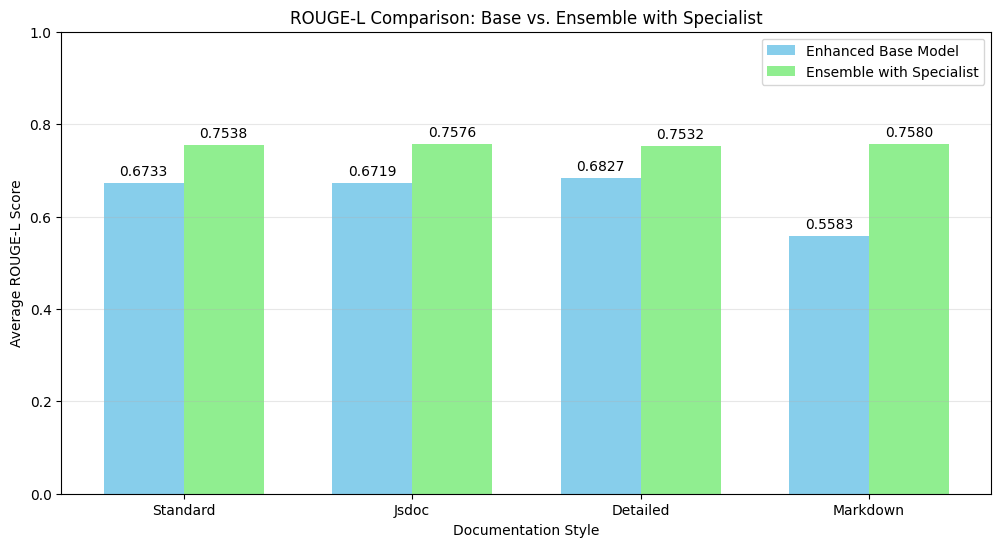

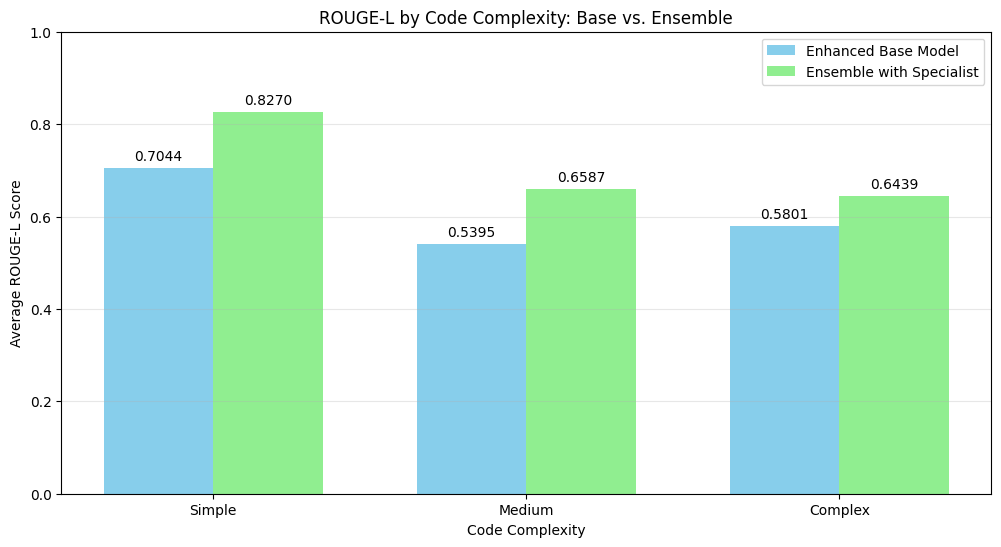

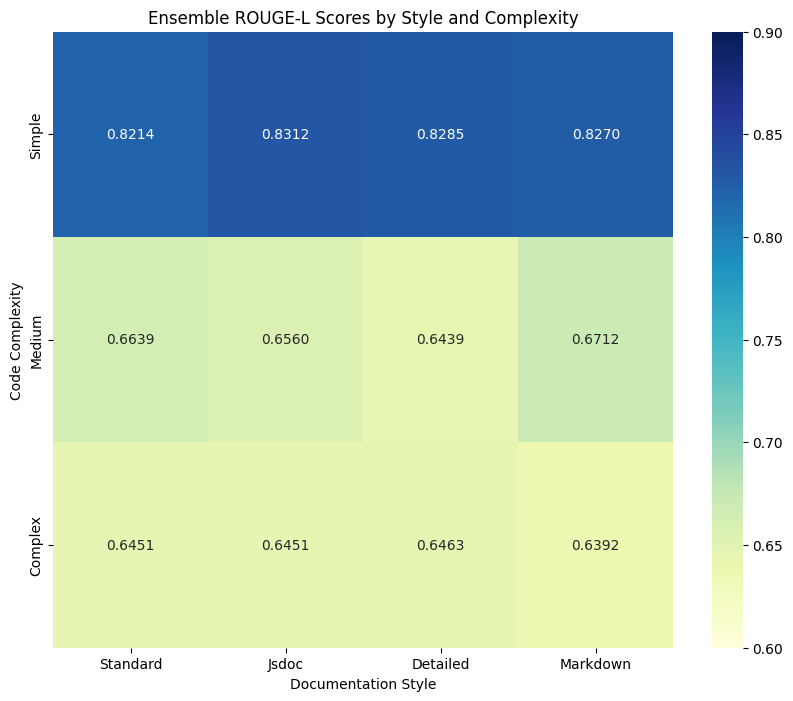

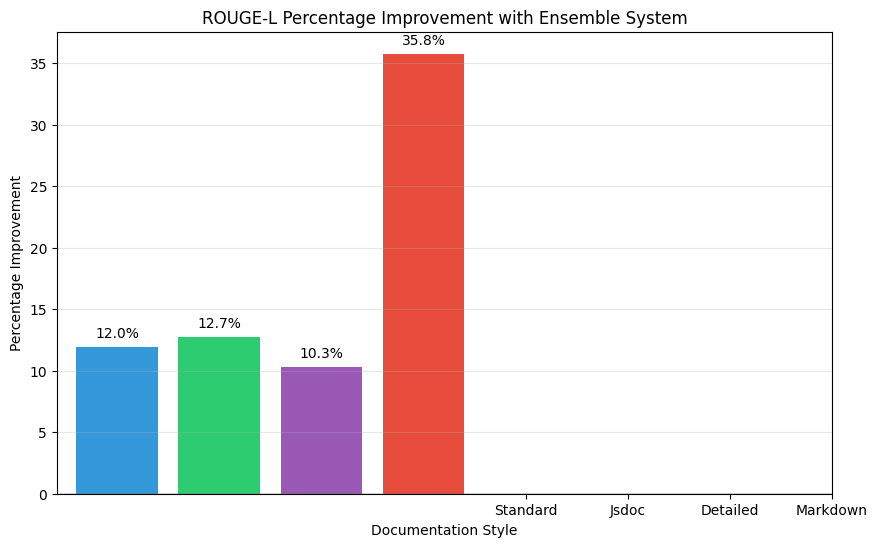


Improvement Percentages:

Overall:
  Standard: 11.96%
  Jsdoc: 12.75%
  Detailed: 10.33%
  Markdown: 35.77%

By Complexity:

Simple:
  Standard: 11.95%
  Jsdoc: 14.14%
  Detailed: 10.70%
  Markdown: 36.19%

Medium:
  Standard: 18.13%
  Jsdoc: 15.52%
  Detailed: 13.43%
  Markdown: 45.80%

Complex:
  Standard: 6.97%
  Jsdoc: 6.26%
  Detailed: 8.16%
  Markdown: 24.72%


In [ ]:
# Create final visualizations
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd
import seaborn as sns

# Verify drive is mounted
if not os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

# Paths
base_eval_path = '/content/drive/MyDrive/ts_documentation/evaluation_results/enhanced_evaluation_results.json'
ensemble_eval_path = '/content/drive/MyDrive/ts_documentation/evaluation_results/ensemble_evaluation_results.json'
output_dir = '/content/drive/MyDrive/ts_documentation/evaluation_results/charts'

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Load evaluation results
with open(base_eval_path, 'r') as f:
    base_results = json.load(f)

with open(ensemble_eval_path, 'r') as f:
    ensemble_results = json.load(f)

# Plot overall ROUGE-L comparison
plt.figure(figsize=(12, 6))
styles = ["standard", "jsdoc", "detailed", "markdown"]
base_scores = [base_results["avg_metrics"][style]["rougeL"] for style in styles]
ensemble_scores = [ensemble_results["avg_metrics"][style]["rougeL"] for style in styles]

x = np.arange(len(styles))
width = 0.35

plt.bar(x - width/2, base_scores, width, label='Enhanced Base Model', color='skyblue')
plt.bar(x + width/2, ensemble_scores, width, label='Ensemble with Specialist', color='lightgreen')

plt.xlabel('Documentation Style')
plt.ylabel('Average ROUGE-L Score')
plt.title('ROUGE-L Comparison: Base vs. Ensemble with Specialist')
plt.xticks(x, [style.capitalize() for style in styles])
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(base_scores):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

for i, v in enumerate(ensemble_scores):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.savefig(f"{output_dir}/overall_rougel_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot complexity comparison
plt.figure(figsize=(12, 6))
complexity_types = ["simple", "medium", "complex"]

# Extract scores
base_complex_scores = []
ensemble_complex_scores = []

for complexity in complexity_types:
    # Calculate average ROUGE-L across all styles for this complexity
    base_score = np.mean([base_results["complexity_metrics"][complexity][style]["rougeL"] for style in styles])
    ensemble_score = np.mean([ensemble_results["complexity_metrics"][complexity][style]["rougeL"] for style in styles])

    base_complex_scores.append(base_score)
    ensemble_complex_scores.append(ensemble_score)

x = np.arange(len(complexity_types))
width = 0.35

plt.bar(x - width/2, base_complex_scores, width, label='Enhanced Base Model', color='skyblue')
plt.bar(x + width/2, ensemble_complex_scores, width, label='Ensemble with Specialist', color='lightgreen')

plt.xlabel('Code Complexity')
plt.ylabel('Average ROUGE-L Score')
plt.title('ROUGE-L by Code Complexity: Base vs. Ensemble')
plt.xticks(x, [c.capitalize() for c in complexity_types])
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(base_complex_scores):
    plt.text(i - width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

for i, v in enumerate(ensemble_complex_scores):
    plt.text(i + width/2, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.savefig(f"{output_dir}/complexity_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Create style vs. complexity heatmap for ensemble
plt.figure(figsize=(10, 8))
heatmap_data = []

for complexity in complexity_types:
    row = []
    for style in styles:
        row.append(ensemble_results["complexity_metrics"][complexity][style]["rougeL"])
    heatmap_data.append(row)

df = pd.DataFrame(heatmap_data, index=[c.capitalize() for c in complexity_types], columns=[s.capitalize() for s in styles])

sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".4f", vmin=0.6, vmax=0.9)
plt.title('Ensemble ROUGE-L Scores by Style and Complexity')
plt.ylabel('Code Complexity')
plt.xlabel('Documentation Style')
plt.savefig(f"{output_dir}/ensemble_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Calculate improvement percentages
improvements = {
    "overall": {},
    "by_complexity": {}
}

# Overall improvements
for style in styles:
    base = base_results["avg_metrics"][style]["rougeL"]
    ensemble = ensemble_results["avg_metrics"][style]["rougeL"]
    improvement = (ensemble - base) / base * 100
    improvements["overall"][style] = improvement

# By complexity
for complexity in complexity_types:
    improvements["by_complexity"][complexity] = {}
    for style in styles:
        base = base_results["complexity_metrics"][complexity][style]["rougeL"]
        ensemble = ensemble_results["complexity_metrics"][complexity][style]["rougeL"]
        improvement = (ensemble - base) / base * 100
        improvements["by_complexity"][complexity][style] = improvement

# Plot overall improvements
plt.figure(figsize=(10, 6))
overall_impr = [improvements["overall"][style] for style in styles]

plt.bar(styles, overall_impr, color=['#3498db', '#2ecc71', '#9b59b6', '#e74c3c'])
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.xlabel('Documentation Style')
plt.ylabel('Percentage Improvement')
plt.title('ROUGE-L Percentage Improvement with Ensemble System')
plt.xticks([s.capitalize() for s in styles])
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(overall_impr):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.savefig(f"{output_dir}/improvement_percentages.png", dpi=300, bbox_inches='tight')
plt.show()

# Save improvement data
with open(f"{output_dir}/improvement_data.json", 'w') as f:
    json.dump(improvements, f, indent=2)

print("\nImprovement Percentages:")
print("\nOverall:")
for style in styles:
    print(f"  {style.capitalize()}: {improvements['overall'][style]:.2f}%")

print("\nBy Complexity:")
for complexity in complexity_types:
    print(f"\n{complexity.capitalize()}:")
    for style in styles:
        print(f"  {style.capitalize()}: {improvements['by_complexity'][complexity][style]:.2f}%")